In [1]:
import numpy as np
from StringIO import StringIO
import pandas as pd
from __future__ import division
import matplotlib.pyplot as plt
import urllib2,base64
import cPickle as pickle
from collections import Counter
from collections import defaultdict
from collections import OrderedDict
from __future__ import division
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter,DayLocator
from matplotlib.font_manager import FontProperties

import scipy as sp
import gdal,ogr
from gdalconst import * 
import datetime
import math
import operator
import re
import os
import os.path
import requests, time
import urllib, json
import csv
import seaborn as sns

from sklearn import neighbors, datasets,linear_model,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import LeavePLabelOut
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import r2_score
from sklearn.preprocessing import minmax_scale
from sklearn import decomposition
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from pylab import *
from scipy import stats
from sklearn.neighbors import DistanceMetric
from urllib2 import urlopen, Request
from pprint import pprint

from scipy.spatial import KDTree
from numpy import linalg as LA
from calendar import monthrange
from sklearn import metrics
import tarfile


import netCDF4
from netCDF4 import Dataset

%matplotlib inline

/home/s132732/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
ill_df=pd.read_csv('data/US_2016_integrated.csv',encoding='utf-8',index_col=0) 
YEAR=2016
#ill_df['timestamp']=pd.to_datetime(ill_df['timestamp'], errors='coerce')
ill_df.shape


/home/s132732/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(5903755, 17)

In [8]:

pixelwidth=0.0416666666667 #PRISM cell size (800m)
width_50=pixelwidth*12.5
width_25=pixelwidth*6.25
### BOunding box for Illinois
westlon=-124.7844079
southlat=24.7433195
eastlon=-66.9513812
northlat=49.3457868

resol_lon= int(round(abs(westlon-eastlon)/width_50))
resol_lat= int(round(abs(southlat-northlat)/width_50))

n_lat, n_lon=(resol_lat, resol_lon)
lat_bins = np.linspace(southlat, northlat, n_lat)
lon_bins = np.linspace(westlon, eastlon, n_lon)

lat_labels=np.arange(resol_lat-1)
lon_labels=np.arange(resol_lon-1)

### Bin all observations
ill_df = ill_df.assign(
    LAT_cut=pd.cut(ill_df.LAT,lat_bins,labels=False),
    LON_cut=pd.cut(ill_df.LON,lon_bins,labels=False)
)

ill_df=ill_df.rename(index=str, columns={"count": "count_daily"})
ill_df['timestamp']=pd.to_datetime(ill_df['timestamp'], errors='coerce')
### Categorize on Urban or NOt
ill_df.dropna(axis=0, how='any',inplace=True)
ill_urban_df=ill_df[ill_df['URBAN']==True]
ill_rural_df=ill_df[ill_df['URBAN']==False]


print "Spatial Bin on LAT/LON with resolution (n_lat, n_lon):",(resol_lat, resol_lon)
#print lat_bins
#print lon_bins
ill_df.head()

Spatial Bin on LAT/LON with resolution (n_lat, n_lon): (47, 111)


,count_daily,LAT,length_daily,LON,timestamp,txt,URBAN,TMAX,TMIN,PRCP,HUM,CC,WIND,POP,month,length_monthly,length_norm,LAT_cut,LON_cut
1,1,25.966147,10,-80.165642,2016-01-01,"[#zordon, better, get, his, uglass, on, @, mia...",True,28.700001,23.840000,0.00,80.75,70.899902,2.424947,2043.7828,1,19.402753,0.515391,2,84
2,1,26.103777,11,-80.263008,2016-01-01,"[hows, my, hung, overs, doing, d, @, fort, lau...",True,29.049999,22.620001,0.00,80.75,70.899902,2.424947,1070.0024,1,19.402753,0.566930,2,84
3,1,27.335461,10,-82.543953,2016-01-01,"[hey, #happynewyear, eh, jessesimms, johnniewa...",True,27.379999,19.490000,0.00,84.50,81.899902,0.431849,2676.7050,1,19.402753,0.515391,4,80
4,1,28.566667,8,-81.205108,2016-01-01,"[#assistfiredept, at, 11801-12022, e, colonial...",True,28.639999,20.299999,0.01,83.00,82.199951,1.872586,1558.8927,1,19.402753,0.412313,7,82
5,1,28.577684,8,-81.465520,2016-01-01,"[#trespasser, at, 6010-6299, silver, star, rd,...",True,28.670000,20.340000,0.00,84.50,82.300049,3.128530,2357.8577,1,19.402753,0.412313,7,82


In [16]:
ill_urban_monthlygrouped_df=ill_urban_df.groupby([ill_urban_df.month,ill_urban_df.LAT_cut,ill_urban_df.LON_cut])['count_daily'].sum().to_frame().reset_index()
ill_rural_monthlygrouped_df=ill_rural_df.groupby([ill_rural_df.month,ill_rural_df.LAT_cut,ill_rural_df.LON_cut])['count_daily'].sum().to_frame().reset_index()

ill_urban_monthlygrouped_df=ill_urban_monthlygrouped_df.rename(index=str, columns={"count_daily": "monthly_cell_count_urban"})
ill_rural_monthlygrouped_df=ill_rural_monthlygrouped_df.rename(index=str, columns={"count_daily": "monthly_cell_count_rural"})

ill_urban_monthlygrouped_df['monthly_cell_daily_count'] = ill_urban_monthlygrouped_df.apply(lambda row: row['monthly_cell_count_urban'] / monthrange(YEAR,int(row.month))[1], axis=1)
ill_rural_monthlygrouped_df['monthly_cell_daily_count'] = ill_rural_monthlygrouped_df.apply(lambda row: row['monthly_cell_count_rural'] / monthrange(YEAR,int(row.month))[1], axis=1)

ill_merge_monthlygrouped_df=pd.merge(ill_urban_monthlygrouped_df, ill_rural_monthlygrouped_df, how='outer', on=['month','LAT_cut','LON_cut'], sort=True,
         suffixes=('_urban', '_rural'))

ill_merge_monthlygrouped_df.fillna(0).head() ##MONTHLY DAILY CELL COUNT

,month,LAT_cut,LON_cut,monthly_cell_count_urban,monthly_cell_daily_count_urban,monthly_cell_count_rural,monthly_cell_daily_count_rural
0,1,0.0,168.0,51.0,1.645161,17.0,0.548387
1,1,0.0,169.0,5.0,0.161290,0.0,0.000000
2,1,1.0,169.0,73.0,2.354839,6.0,0.193548
3,1,2.0,168.0,0.0,0.000000,9.0,0.290323
4,1,2.0,169.0,153.0,4.935484,21.0,0.677419


In [17]:
ill_urban_dailygrouped_df=ill_urban_df.groupby([ill_urban_df.timestamp,ill_urban_df.LAT_cut,ill_urban_df.LON_cut]).agg({'count_daily':'sum','TMAX':'mean','TMIN':'mean','PRCP':'mean','HUM':'mean','CC':'mean','WIND':'mean','month':'first'}).reset_index()
ill_rural_dailygrouped_df=ill_rural_df.groupby([ill_rural_df.timestamp,ill_rural_df.LAT_cut,ill_rural_df.LON_cut]).agg({'count_daily':'sum','TMAX':'mean','TMIN':'mean','PRCP':'mean','HUM':'mean','CC':'mean','WIND':'mean','month':'first'}).reset_index()
#ill_rural_dailygrouped_df=ill_rural_df.groupby([ill_rural_df.timestamp,ill_rural_df.LAT_cut,ill_rural_df.LON_cut])['count_daily'].sum().to_frame().reset_index()

ill_merge_dailygrouped_df=pd.merge(ill_urban_dailygrouped_df, ill_rural_dailygrouped_df, how='outer', on=['timestamp','LAT_cut','LON_cut','month'], sort=True, suffixes=('_urban', '_rural'))

ill_merge_daily_df=pd.merge(ill_merge_dailygrouped_df,ill_merge_monthlygrouped_df, how="left", on=['LAT_cut','LON_cut','month'])

ill_merge_daily_df=ill_merge_daily_df
#f, ax = plt.subplots(1, 1, sharey=True)
#f.set_size_inches(18.5, 10.5, forward=True)

#test=ill_merge_daily_df[ill_merge_daily_df['timestamp']=='2016-02-21']
#plt.scatter(test['LON_cut'], test['LAT_cut'], s=700, c=test['PRCP_rural'], cmap="Reds", alpha=0.5,edgecolors=None,linewidths=0)
ill_merge_daily_df.head()

,timestamp,LAT_cut,LON_cut,count_daily_urban,TMIN_urban,CC_urban,HUM_urban,TMAX_urban,PRCP_urban,WIND_urban,...,TMIN_rural,CC_rural,HUM_rural,TMAX_rural,PRCP_rural,WIND_rural,monthly_cell_count_urban,monthly_cell_daily_count_urban,monthly_cell_count_rural,monthly_cell_daily_count_rural
0,2016-01-01,0.0,168.0,1.0,25.090000,70.899902,80.75,28.260000,0.800000,2.424947,...,25.090000,70.899902,80.75,28.260000,0.8,2.424947,51.0,1.645161,17.0,0.548387
1,2016-01-01,1.0,169.0,6.0,24.966666,70.899902,80.75,28.675000,0.098333,2.424947,...,NaN,NaN,NaN,NaN,NaN,NaN,73.0,2.354839,6.0,0.193548
2,2016-01-01,2.0,169.0,4.0,21.677500,70.899902,80.75,29.045000,1.002500,2.424947,...,NaN,NaN,NaN,NaN,NaN,NaN,153.0,4.935484,21.0,0.677419
3,2016-01-01,3.0,169.0,57.0,22.164490,70.899902,80.75,28.725306,0.797551,2.424947,...,22.290000,70.899902,80.75,28.836666,0.8,2.424947,1543.0,49.774194,128.0,4.129032
4,2016-01-01,3.0,170.0,206.0,24.464121,70.899902,80.75,28.550545,0.005333,2.424947,...,24.778572,70.899902,80.75,28.802857,0.0,2.424947,4943.0,159.451613,67.0,2.161290


In [18]:
###ADD HISTORIC NORM 

###### ADD PRISM HISTORIC NORMS
originX,pixelWidth,b,originY,d,pixelHeight=(-125.02083333333336, 0.0416666666667, 0.0, 49.93749999999975, 0.0, -0.0416666666667)
lat_inds=np.floor(np.absolute((lat_bins -  originY) / pixelHeight)).astype(int)
lon_inds=np.floor(np.absolute((lon_bins -  originX) / pixelWidth)).astype(int)

ill_merge_daily_df['timestamp']=ill_merge_daily_df['timestamp'].dt.strftime("%Y-%m-%d")
#lat_inds = lat_inds[ill_merge_daily_df['LAT_cut'].astype(int)]
#lon_inds = lon_inds[ill_merge_daily_df['LON_cut'].astype(int)]

weather_factors=['TMAX','TMIN','PRCP']
month_days=[x[5:7]+x[8:10] for x in ill_merge_daily_df['timestamp'].unique().tolist()]
for weather_factor in weather_factors:
    with open('data/'+weather_factor+'_mean.pickle', 'rb') as handle:
        data_dict = pickle.load(handle)

    his_mean_df=pd.DataFrame(data_dict.items(),columns=['timestamp', 'HIS_mean_std'])
    his_mean_df[['HIS_mean', 'HIS_std']] = his_mean_df['HIS_mean_std'].apply(pd.Series)
    his_mean_df.drop('HIS_mean_std', axis=1, inplace=True)

    mean_list=list()

    for month_day in month_days:
        ill_month_day_df=ill_merge_daily_df[(ill_merge_daily_df.timestamp.str.slice(5,7)==month_day[0:2]) & (ill_merge_daily_df.timestamp.str.slice(8,10)==month_day[2:4])]
        ill_month_day_img=his_mean_df[his_mean_df['timestamp']==month_day]['HIS_mean'].values[0]

        plat_inds= lat_inds[ill_month_day_df['LAT_cut'].astype(int)]
        plon_inds= lon_inds[ill_month_day_df['LON_cut'].astype(int)]

        mean_list.extend(ill_month_day_img[plat_inds,plon_inds])
        #print ill_month_day_df.shape, " the lookup size: ",len(lat_inds)
        print month_day + " DATE DONE"

    print weather_factor + " LOAD HISORIC Complete"
    ill_merge_daily_df[weather_factor+'_HIS_mean']=mean_list
#for lat, lon in zip()



0101 DATE DONE
0102 DATE DONE
0103 DATE DONE
0104 DATE DONE
0105 DATE DONE
0106 DATE DONE
0107 DATE DONE
0108 DATE DONE
0109 DATE DONE
0110 DATE DONE
0111 DATE DONE
0112 DATE DONE
0113 DATE DONE
0114 DATE DONE
0115 DATE DONE
0116 DATE DONE
0117 DATE DONE
0118 DATE DONE
0119 DATE DONE
0120 DATE DONE
0121 DATE DONE
0122 DATE DONE
0123 DATE DONE
0124 DATE DONE
0125 DATE DONE
0126 DATE DONE
0127 DATE DONE
0128 DATE DONE
0129 DATE DONE
0130 DATE DONE
0131 DATE DONE
0201 DATE DONE
0202 DATE DONE
0203 DATE DONE
0204 DATE DONE
0205 DATE DONE
0206 DATE DONE
0207 DATE DONE
0208 DATE DONE
0209 DATE DONE
0210 DATE DONE
0211 DATE DONE
0212 DATE DONE
0213 DATE DONE
0214 DATE DONE
0215 DATE DONE
0216 DATE DONE
0217 DATE DONE
0218 DATE DONE
0219 DATE DONE
0220 DATE DONE
0221 DATE DONE
0222 DATE DONE
0223 DATE DONE
0224 DATE DONE
0225 DATE DONE
0226 DATE DONE
0227 DATE DONE
0228 DATE DONE
0229 DATE DONE
0301 DATE DONE
0302 DATE DONE
0303 DATE DONE
0304 DATE DONE
0305 DATE DONE
0306 DATE DONE
0307 DATE 

0628 DATE DONE
0629 DATE DONE
0630 DATE DONE
0701 DATE DONE
0702 DATE DONE
0703 DATE DONE
0704 DATE DONE
0705 DATE DONE
0706 DATE DONE
0707 DATE DONE
0708 DATE DONE
0709 DATE DONE
0710 DATE DONE
0711 DATE DONE
0712 DATE DONE
0713 DATE DONE
0714 DATE DONE
0715 DATE DONE
0716 DATE DONE
0717 DATE DONE
0718 DATE DONE
0719 DATE DONE
0720 DATE DONE
0721 DATE DONE
0722 DATE DONE
0723 DATE DONE
0724 DATE DONE
0725 DATE DONE
0726 DATE DONE
0727 DATE DONE
0728 DATE DONE
0729 DATE DONE
0730 DATE DONE
0731 DATE DONE
0801 DATE DONE
0802 DATE DONE
0803 DATE DONE
0804 DATE DONE
0805 DATE DONE
0806 DATE DONE
0807 DATE DONE
0808 DATE DONE
0809 DATE DONE
0810 DATE DONE
0811 DATE DONE
0812 DATE DONE
0813 DATE DONE
0814 DATE DONE
0815 DATE DONE
0816 DATE DONE
0817 DATE DONE
0818 DATE DONE
0819 DATE DONE
0820 DATE DONE
0821 DATE DONE
0822 DATE DONE
0823 DATE DONE
0824 DATE DONE
0825 DATE DONE
0826 DATE DONE
0827 DATE DONE
0828 DATE DONE
0829 DATE DONE
0830 DATE DONE
0831 DATE DONE
0901 DATE DONE
0902 DATE 

1224 DATE DONE
1225 DATE DONE
1226 DATE DONE
1227 DATE DONE
1228 DATE DONE
1229 DATE DONE
1230 DATE DONE
1231 DATE DONE
PRCP LOAD HISORIC Complete


In [9]:
ill_merge_daily_df=pd.read_csv('data/US_2016_50KMbinned.csv',encoding='utf-8',index_col=0)

In [ ]:
###### ADD NCEP HISTORIC NORMS
weather_factors=['HUM','WIND','CC']

month_days=[x[5:7]+x[8:10] for x in ill_merge_daily_df['timestamp'].unique().tolist()]
for weather_factor in weather_factors:
    with open('data/'+weather_factor+'_mean.pickle', 'rb') as handle:
        data_dict = pickle.load(handle)
        
    if weather_factor=='HUM':
        lat_inds=np.rint((90 - lat_bins)/(180/73)).astype(int)
        lon_inds=np.rint((lon_bins % 360)/(360/144)).astype(int)
    else:
        lat_inds=np.rint((90 - lat_bins)/(180/94)).astype(int)
        lon_inds=np.rint((lon_bins % 360)/(360/192)).astype(int)
    
    his_mean_df=pd.DataFrame(data_dict.items(),columns=['timestamp', 'HIS_mean_std'])
    his_mean_df[['HIS_mean', 'HIS_std']] = his_mean_df['HIS_mean_std'].apply(pd.Series)
    his_mean_df.drop('HIS_mean_std', axis=1, inplace=True)
    
    mean_list=list()
    
    for month_day in month_days:
        ill_month_day_df=ill_merge_daily_df[(ill_merge_daily_df.timestamp.str.slice(5,7)==month_day[0:2]) & (ill_merge_daily_df.timestamp.str.slice(8,10)==month_day[2:4])]
        ill_month_day_img=his_mean_df[his_mean_df['timestamp']==month_day]['HIS_mean'].values[0]
        nlat_inds= lat_inds[ill_month_day_df['LAT_cut'].astype(int)]
        nlon_inds= lon_inds[ill_month_day_df['LON_cut'].astype(int)]
        
        mean_list.extend(ill_month_day_img[nlat_inds,nlon_inds])
        print month_day + " DATE DONE"
    
    print weather_factor + " LOAD HISORIC Complete"
    ill_merge_daily_df[weather_factor+'_HIS_mean']=mean_list

0101 DATE DONE
0102 DATE DONE
0103 DATE DONE
0104 DATE DONE
0105 DATE DONE
0106 DATE DONE
0107 DATE DONE
0108 DATE DONE
0109 DATE DONE
0110 DATE DONE
0111 DATE DONE
0112 DATE DONE
0113 DATE DONE
0114 DATE DONE
0115 DATE DONE
0116 DATE DONE
0117 DATE DONE
0118 DATE DONE
0119 DATE DONE
0120 DATE DONE
0121 DATE DONE
0122 DATE DONE
0123 DATE DONE
0124 DATE DONE
0125 DATE DONE
0126 DATE DONE
0127 DATE DONE
0128 DATE DONE
0129 DATE DONE
0130 DATE DONE
0131 DATE DONE
0201 DATE DONE
0202 DATE DONE
0203 DATE DONE
0204 DATE DONE
0205 DATE DONE
0206 DATE DONE
0207 DATE DONE
0208 DATE DONE
0209 DATE DONE
0210 DATE DONE
0211 DATE DONE
0212 DATE DONE
0213 DATE DONE
0214 DATE DONE
0215 DATE DONE
0216 DATE DONE
0217 DATE DONE
0218 DATE DONE
0219 DATE DONE
0220 DATE DONE
0221 DATE DONE
0222 DATE DONE
0223 DATE DONE
0224 DATE DONE
0225 DATE DONE
0226 DATE DONE
0227 DATE DONE
0228 DATE DONE
0229 DATE DONE
0301 DATE DONE
0302 DATE DONE
0303 DATE DONE
0304 DATE DONE
0305 DATE DONE
0306 DATE DONE
0307 DATE 

0628 DATE DONE
0629 DATE DONE
0630 DATE DONE
0701 DATE DONE
0702 DATE DONE
0703 DATE DONE
0704 DATE DONE
0705 DATE DONE
0706 DATE DONE
0707 DATE DONE
0708 DATE DONE
0709 DATE DONE
0710 DATE DONE
0711 DATE DONE
0712 DATE DONE
0713 DATE DONE
0714 DATE DONE
0715 DATE DONE
0716 DATE DONE
0717 DATE DONE
0718 DATE DONE
0719 DATE DONE
0720 DATE DONE
0721 DATE DONE
0722 DATE DONE
0723 DATE DONE
0724 DATE DONE
0725 DATE DONE
0726 DATE DONE
0727 DATE DONE
0728 DATE DONE
0729 DATE DONE
0730 DATE DONE
0731 DATE DONE
0801 DATE DONE
0802 DATE DONE
0803 DATE DONE
0804 DATE DONE
0805 DATE DONE
0806 DATE DONE
0807 DATE DONE
0808 DATE DONE
0809 DATE DONE
0810 DATE DONE
0811 DATE DONE
0812 DATE DONE
0813 DATE DONE
0814 DATE DONE
0815 DATE DONE
0816 DATE DONE
0817 DATE DONE
0818 DATE DONE
0819 DATE DONE
0820 DATE DONE
0821 DATE DONE
0822 DATE DONE
0823 DATE DONE
0824 DATE DONE
0825 DATE DONE
0826 DATE DONE
0827 DATE DONE
0828 DATE DONE
0829 DATE DONE
0830 DATE DONE
0831 DATE DONE
0901 DATE DONE
0902 DATE 

In [20]:
ill_merge_daily_df['ncount_daily_urban']=ill_merge_daily_df['count_daily_urban']- ill_merge_daily_df['monthly_cell_daily_count_urban']
ill_merge_daily_df['ncount_daily_rural']=ill_merge_daily_df['count_daily_rural']- ill_merge_daily_df['monthly_cell_daily_count_rural']

In [7]:
print ill_merge_daily_df.columns
print "##################################################"
print "Data Shape - ", ill_merge_daily_df.shape
ill_merge_daily_df['cell_id']=list(zip(ill_merge_daily_df.LAT_cut, ill_merge_daily_df.LON_cut))
ill_merge_daily_df.to_csv('data/US_2016_50KMbinned.csv',encoding='utf-8')

Index([u'timestamp', u'LAT_cut', u'LON_cut', u'count_daily_urban',
       u'TMIN_urban', u'CC_urban', u'HUM_urban', u'TMAX_urban', u'PRCP_urban',
       u'WIND_urban', u'month', u'count_daily_rural', u'TMIN_rural',
       u'CC_rural', u'HUM_rural', u'TMAX_rural', u'PRCP_rural', u'WIND_rural',
       u'monthly_cell_count_urban', u'monthly_cell_daily_count_urban',
       u'monthly_cell_count_rural', u'monthly_cell_daily_count_rural',
       u'TMAX_HIS_mean', u'TMIN_HIS_mean', u'PRCP_HIS_mean', u'HUM_HIS_mean',
       u'WIND_HIS_mean', u'CC_HIS_mean', u'ncount_daily_urban',
       u'ncount_daily_rural', u'cell_id'],
      dtype='object')
##################################################
Data Shape -  (891806, 31)


In [121]:
#ill_merge_daily_df['ncount_daily_rural'].corr(ill_merge_daily_df['PRCP_rural'])
print "Rural Characters Correlation"
ill_merge_daily_df[ill_merge_daily_df.columns[ill_merge_daily_df.columns.to_series().str.contains('rural')]].corr()

Rural Characters Correlation


,TMIN_rural,CC_HIS_mean_rural,CC_rural,count_daily_rural,HUM_HIS_mean_rural,HUM_rural,TMAX_rural,TMAX_HIS_mean_rural,WIND_HIS_mean_rural,TMIN_HIS_mean_rural,PRCP_HIS_mean_rural,PRCP_rural,WIND_rural,monthly_cell_count_rural,monthly_cell_daily_count_rural,ncount_daily_rural
TMIN_rural,1.000000,0.513454,0.448747,0.307594,0.604809,0.570148,0.893886,0.879545,0.483689,0.945104,0.491097,0.212839,0.310563,0.218691,0.217416,0.232480
CC_HIS_mean_rural,0.513454,1.000000,0.610438,0.382802,0.861551,0.819934,0.736742,0.750386,0.874925,0.499567,0.646693,0.199280,0.692212,0.222185,0.222376,0.375287
CC_rural,0.448747,0.610438,1.000000,0.285459,0.685498,0.763855,0.549745,0.549147,0.639776,0.361649,0.566811,0.331800,0.587945,0.158337,0.158242,0.293386
count_daily_rural,0.307594,0.382802,0.285459,1.000000,0.424053,0.387247,0.386615,0.392655,0.366849,0.301337,0.284912,0.082225,0.322572,0.868314,0.868517,0.467420
HUM_HIS_mean_rural,0.604809,0.861551,0.685498,0.424053,1.000000,0.938571,0.844963,0.853019,0.890357,0.579496,0.716873,0.221578,0.754240,0.241377,0.241380,0.424575
HUM_rural,0.570148,0.819934,0.763855,0.387247,0.938571,1.000000,0.756356,0.767692,0.861739,0.510831,0.727246,0.302686,0.738825,0.212399,0.212214,0.402376
TMAX_rural,0.893886,0.736742,0.549745,0.386615,0.844963,0.756356,1.000000,0.970572,0.726255,0.862676,0.613321,0.188802,0.531107,0.241294,0.240697,0.350300
TMAX_HIS_mean_rural,0.879545,0.750386,0.549147,0.392655,0.853019,0.767692,0.970572,1.000000,0.734734,0.899929,0.617858,0.205093,0.524922,0.246417,0.245603,0.353731
WIND_HIS_mean_rural,0.483689,0.874925,0.639776,0.366849,0.890357,0.861739,0.726255,0.734734,1.000000,0.458890,0.686954,0.215875,0.702278,0.193627,0.194024,0.393687
TMIN_HIS_mean_rural,0.945104,0.499567,0.361649,0.301337,0.579496,0.510831,0.862676,0.899929,0.458890,1.000000,0.481833,0.169172,0.255995,0.219155,0.217789,0.219199


In [122]:
print "Urban Characters Correlation"
ill_merge_daily_df[ill_merge_daily_df.columns[ill_merge_daily_df.columns.to_series().str.contains('urban')]].corr()

Urban Characters Correlation


,TMIN_urban,CC_HIS_mean_urban,CC_urban,count_daily_urban,HUM_HIS_mean_urban,HUM_urban,TMAX_urban,TMAX_HIS_mean_urban,WIND_HIS_mean_urban,TMIN_HIS_mean_urban,PRCP_HIS_mean_urban,PRCP_urban,WIND_urban,monthly_cell_count_urban,monthly_cell_daily_count_urban,ncount_daily_urban
TMIN_urban,1.000000,0.304641,0.264779,0.090006,0.422788,0.372834,0.884489,0.863567,0.250433,0.929290,0.349291,0.159672,0.034000,0.089056,0.088179,0.017211
CC_HIS_mean_urban,0.304641,1.000000,0.394528,0.103726,0.715081,0.638486,0.517676,0.540644,0.752654,0.306057,0.448009,0.117952,0.480593,0.098559,0.098583,0.035318
CC_urban,0.264779,0.394528,1.000000,0.059438,0.508339,0.642960,0.308927,0.303979,0.431035,0.162095,0.371299,0.292862,0.401466,0.056287,0.056175,0.021852
count_daily_urban,0.090006,0.103726,0.059438,1.000000,0.115124,0.095522,0.092473,0.095233,0.076757,0.091197,0.057652,0.010515,0.086371,0.980993,0.981223,0.183494
HUM_HIS_mean_urban,0.422788,0.715081,0.508339,0.115124,1.000000,0.867639,0.690119,0.702648,0.772260,0.403042,0.551185,0.144946,0.580946,0.107843,0.107720,0.047845
HUM_urban,0.372834,0.638486,0.642960,0.095522,0.867639,1.000000,0.528830,0.544629,0.710254,0.295180,0.556138,0.264946,0.552996,0.089106,0.088852,0.042380
TMAX_urban,0.884489,0.517676,0.308927,0.092473,0.690119,0.528830,1.000000,0.946309,0.495481,0.847697,0.425623,0.108735,0.221252,0.088412,0.087881,0.031522
TMAX_HIS_mean_urban,0.863567,0.540644,0.303979,0.095233,0.702648,0.544629,0.946309,1.000000,0.508103,0.907244,0.435827,0.127961,0.202303,0.091119,0.090417,0.032910
WIND_HIS_mean_urban,0.250433,0.752654,0.431035,0.076757,0.772260,0.710254,0.495481,0.508103,1.000000,0.235699,0.493428,0.132162,0.493119,0.069468,0.069646,0.042978
TMIN_HIS_mean_urban,0.929290,0.306057,0.162095,0.091197,0.403042,0.295180,0.847697,0.907244,0.235699,1.000000,0.355854,0.111634,-0.026392,0.090870,0.089950,0.014366


### Sune !!!!

> Binning based on real weather readings and population density

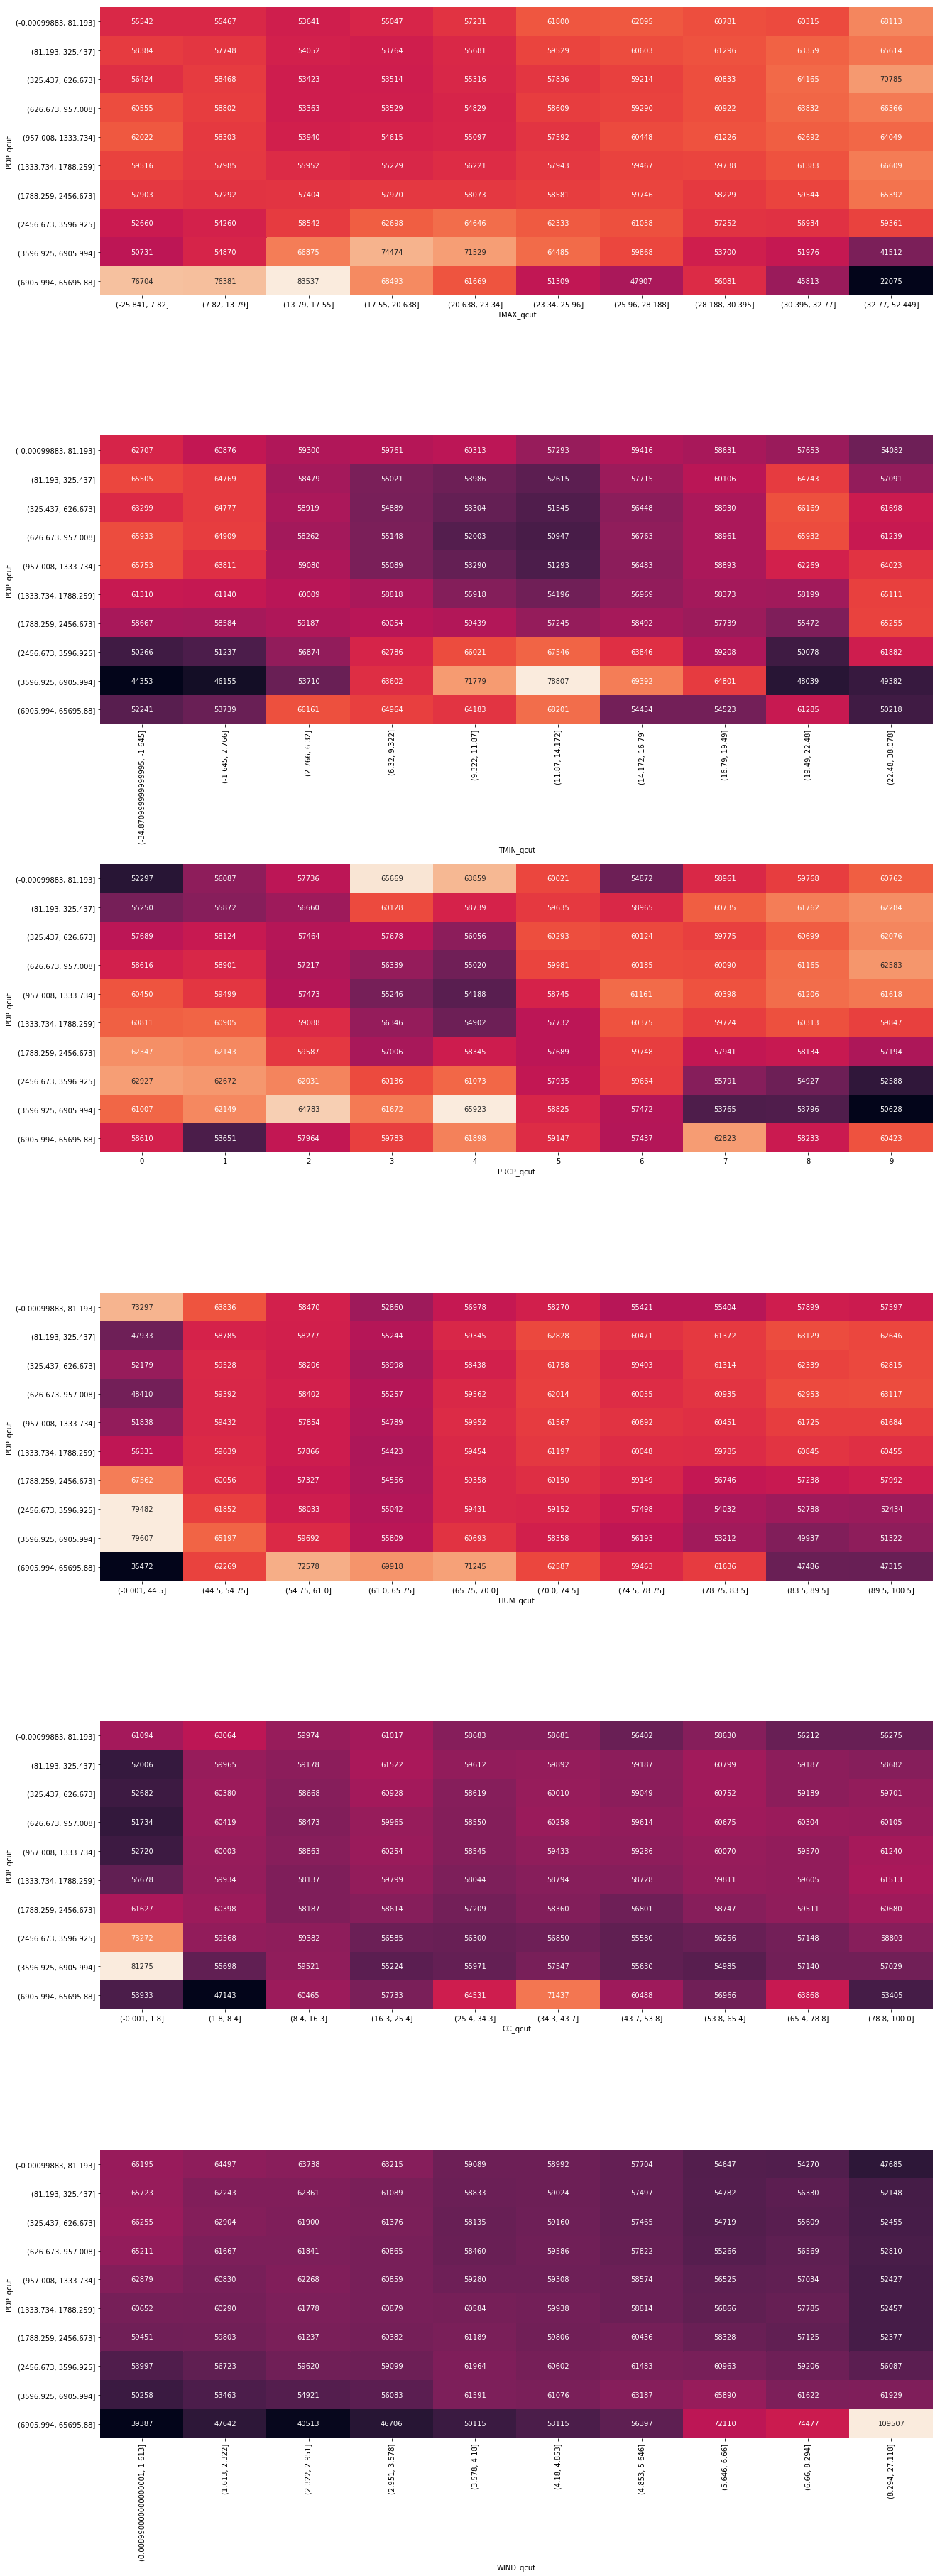

In [19]:
ill_df = ill_df.assign(
    POP_qcut=pd.qcut(ill_df.POP,10),
    TMAX_qcut=pd.qcut(ill_df.TMAX,10),
    TMIN_qcut=pd.qcut(ill_df.TMIN,10),
    PRCP_qcut=pd.qcut(ill_df.PRCP.rank(method='first').values,10).codes,
    HUM_qcut=pd.qcut(ill_df.HUM,10),
    CC_qcut=pd.qcut(ill_df.CC,10),
    WIND_qcut=pd.qcut(ill_df.WIND,10),
)

pop_tmax_df=ill_df.groupby([ill_df.POP_qcut,ill_df.TMAX_qcut])['count_daily'].size().to_frame().reset_index()
pop_tmin_df=ill_df.groupby([ill_df.POP_qcut,ill_df.TMIN_qcut])['count_daily'].size().to_frame().reset_index()
pop_prcp_df=ill_df.groupby([ill_df.POP_qcut,ill_df.PRCP_qcut])['count_daily'].size().to_frame().reset_index()
pop_hum_df=ill_df.groupby([ill_df.POP_qcut,ill_df.HUM_qcut])['count_daily'].size().to_frame().reset_index()
pop_cc_df=ill_df.groupby([ill_df.POP_qcut,ill_df.CC_qcut])['count_daily'].size().to_frame().reset_index()
pop_wind_df=ill_df.groupby([ill_df.POP_qcut,ill_df.WIND_qcut])['count_daily'].size().to_frame().reset_index()

pop_tmax_heatmap_df=pop_tmax_df.pivot('POP_qcut','TMAX_qcut','count_daily')
pop_tmin_heatmap_df=pop_tmin_df.pivot('POP_qcut','TMIN_qcut','count_daily')
pop_prcp_heatmap_df=pop_prcp_df.pivot('POP_qcut','PRCP_qcut','count_daily')
pop_hum_heatmap_df=pop_hum_df.pivot('POP_qcut','HUM_qcut','count_daily')
pop_cc_heatmap_df=pop_cc_df.pivot('POP_qcut','CC_qcut','count_daily')
pop_wind_heatmap_df=pop_wind_df.pivot('POP_qcut','WIND_qcut','count_daily')

f, axarr = plt.subplots(6, 1, sharey=True)
f.set_size_inches(18.5, 50.5, forward=True)
ax = sns.heatmap(pop_tmax_heatmap_df,ax=axarr[0],annot=True, fmt="d",cbar=False)
ax = sns.heatmap(pop_tmin_heatmap_df,ax=axarr[1],annot=True, fmt="d",cbar=False)
ax = sns.heatmap(pop_prcp_heatmap_df,ax=axarr[2],annot=True, fmt="d",cbar=False)
ax = sns.heatmap(pop_hum_heatmap_df,ax=axarr[3],annot=True, fmt="d",cbar=False)
ax = sns.heatmap(pop_cc_heatmap_df,ax=axarr[4],annot=True, fmt="d",cbar=False)
ax = sns.heatmap(pop_wind_heatmap_df,ax=axarr[5],annot=True, fmt="d",cbar=False)
#ill_urban_df=ill_df[ill_df['URBAN']==True]
#ill_rural_df=ill_df[ill_df['URBAN']==False]

#ill_urban_grouped_df=ill_urban_df.groupby([ill_urban_df.POP_qcut])['count'].sum().to_frame().reset_index()
#ill_rural_grouped_df=ill_rural_df.groupby([ill_rural_df.POP_qcut])['count'].sum().to_frame().reset_index()

#ill_urban_grouped_df.head()
#axes=ill_df[ill_df['URBAN']==True].plot(kind='hexbin', x='TMAX', y='POP_qcut', gridsize=20,colormap='Reds',sharex=False)
f.tight_layout()
f.savefig('US_heatmap_'+str(YEAR)+'_pop.png')  

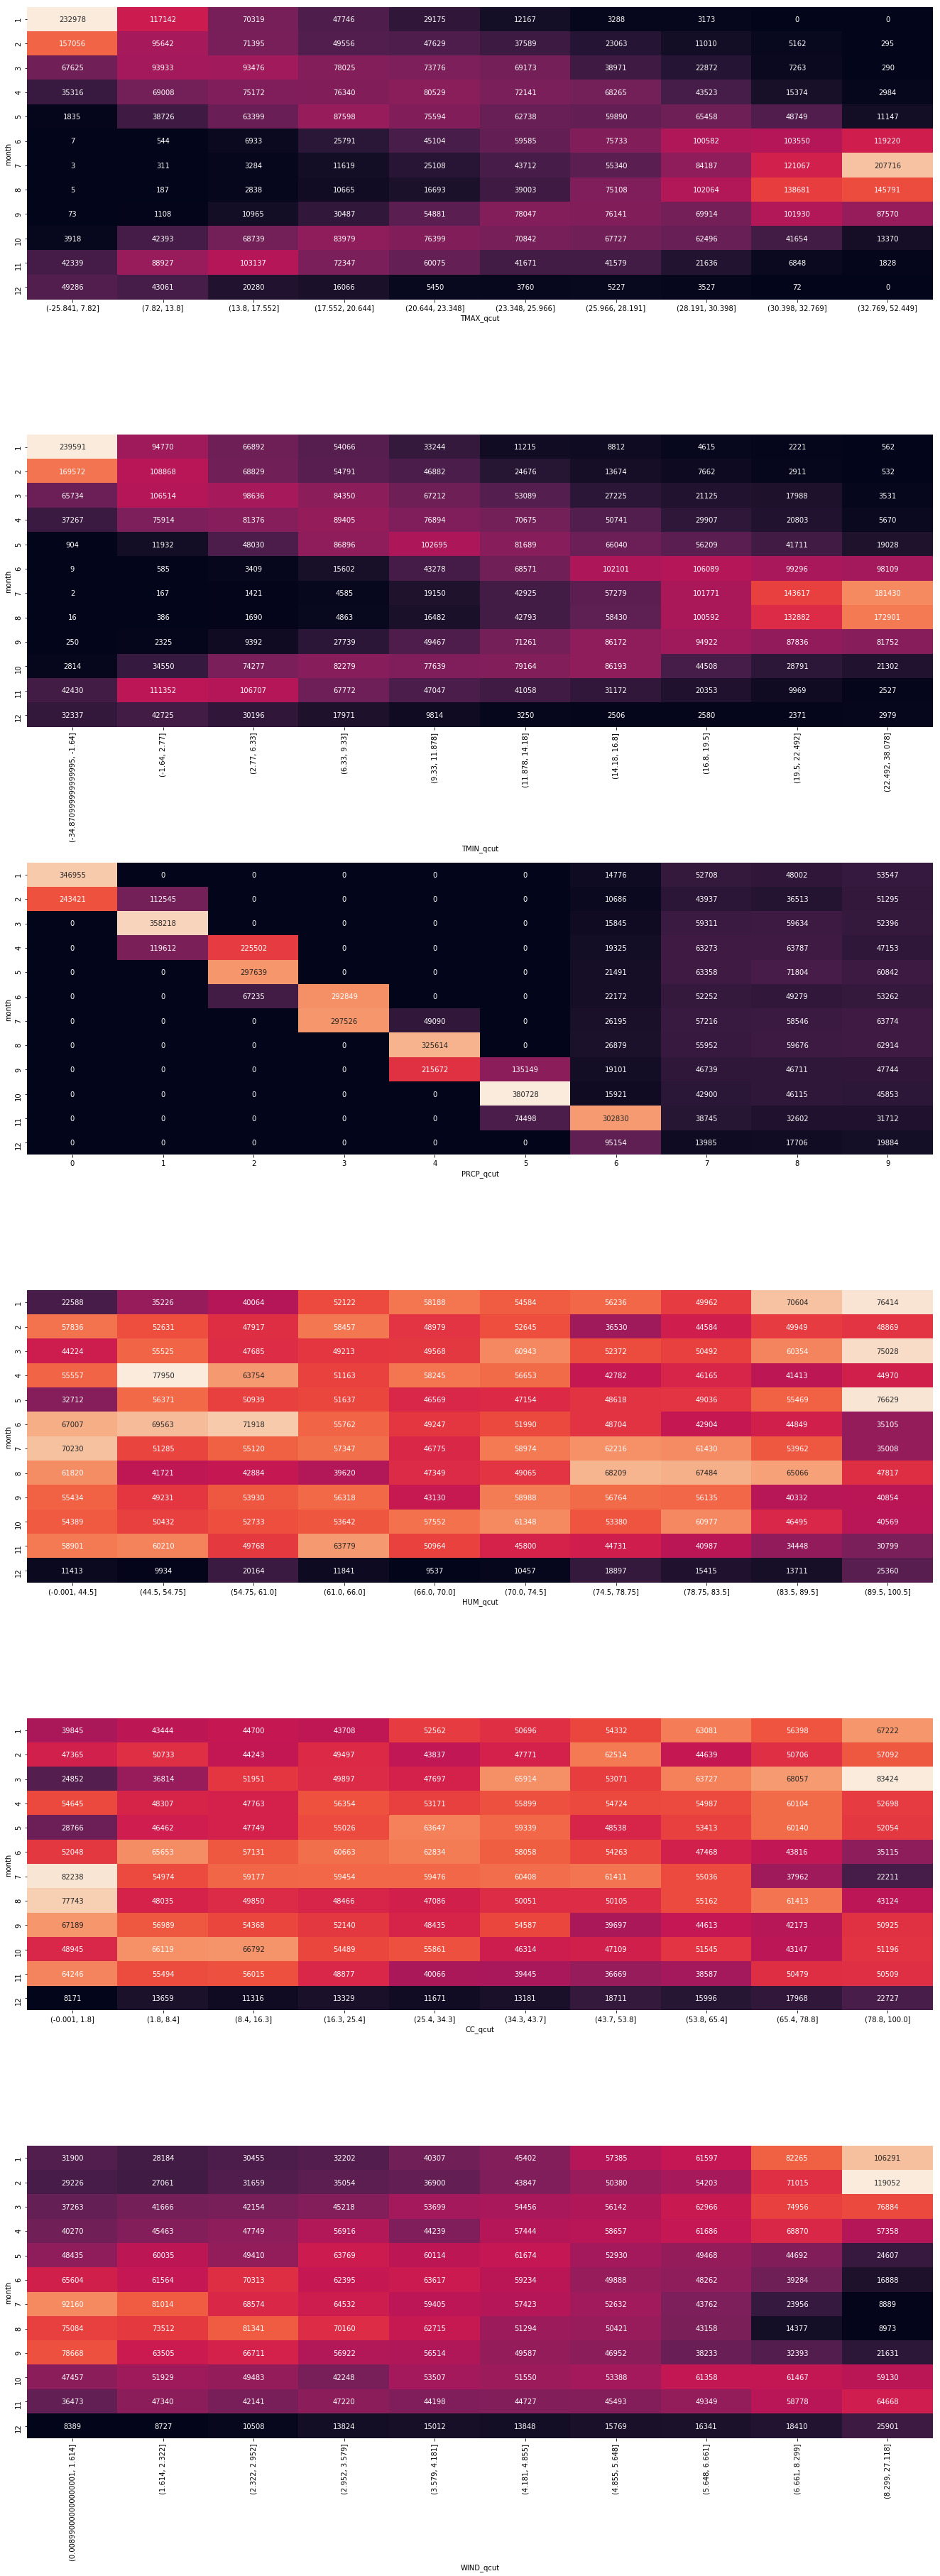

In [58]:
f, axarr = plt.subplots(6, 1, sharey=True)
f.set_size_inches(18.5, 50.5, forward=True)

mon_tmax_df=ill_df.groupby([ill_df.month,ill_df.TMAX_qcut])['count_daily'].size().to_frame().reset_index()
mon_tmin_df=ill_df.groupby([ill_df.month,ill_df.TMIN_qcut])['count_daily'].size().to_frame().reset_index()
mon_prcp_df=ill_df.groupby([ill_df.month,ill_df.PRCP_qcut])['count_daily'].size().to_frame().reset_index()
mon_hum_df=ill_df.groupby([ill_df.month,ill_df.HUM_qcut])['count_daily'].size().to_frame().reset_index()
mon_cc_df=ill_df.groupby([ill_df.month,ill_df.CC_qcut])['count_daily'].size().to_frame().reset_index()
mon_wind_df=ill_df.groupby([ill_df.month,ill_df.WIND_qcut])['count_daily'].size().to_frame().reset_index()

mon_tmax_heatmap_df=mon_tmax_df.pivot('month','TMAX_qcut','count_daily')
mon_tmin_heatmap_df=mon_tmin_df.pivot('month','TMIN_qcut','count_daily')
mon_prcp_heatmap_df=mon_prcp_df.pivot('month','PRCP_qcut','count_daily')
mon_hum_heatmap_df=mon_hum_df.pivot('month','HUM_qcut','count_daily')
mon_cc_heatmap_df=mon_cc_df.pivot('month','CC_qcut','count_daily')
mon_wind_heatmap_df=mon_wind_df.pivot('month','WIND_qcut','count_daily')

mon_tmax_heatmap_df[mon_tmax_heatmap_df.columns.tolist()] = mon_tmax_heatmap_df[mon_tmax_heatmap_df.columns.tolist()].fillna(0).astype(np.int64,errors="ignore")
mon_tmin_heatmap_df[mon_tmin_heatmap_df.columns.tolist()] = mon_tmin_heatmap_df[mon_tmin_heatmap_df.columns.tolist()].fillna(0).astype(np.int64,errors="ignore")
mon_prcp_heatmap_df[mon_prcp_heatmap_df.columns.tolist()] = mon_prcp_heatmap_df[mon_prcp_heatmap_df.columns.tolist()].fillna(0).astype(np.int64,errors="ignore")
mon_hum_heatmap_df[mon_hum_heatmap_df.columns.tolist()] = mon_hum_heatmap_df[mon_hum_heatmap_df.columns.tolist()].fillna(0).astype(np.int64,errors="ignore")
mon_cc_heatmap_df[mon_cc_heatmap_df.columns.tolist()] = mon_cc_heatmap_df[mon_cc_heatmap_df.columns.tolist()].fillna(0).astype(np.int64,errors="ignore")
mon_wind_heatmap_df[mon_wind_heatmap_df.columns.tolist()] = mon_wind_heatmap_df[mon_wind_heatmap_df.columns.tolist()].fillna(0).astype(np.int64,errors="ignore")

ax = sns.heatmap(mon_tmax_heatmap_df, annot=True, fmt="d", ax=axarr[0],cbar=False)
ax = sns.heatmap(mon_tmin_heatmap_df, annot=True, fmt="d", ax=axarr[1],cbar=False)
ax = sns.heatmap(mon_prcp_heatmap_df, annot=True, fmt="d", ax=axarr[2],cbar=False)
ax = sns.heatmap(mon_hum_heatmap_df, annot=True, fmt="d", ax=axarr[3],cbar=False)
ax = sns.heatmap(mon_cc_heatmap_df, annot=True, fmt="d", ax=axarr[4],cbar=False)
ax = sns.heatmap(mon_wind_heatmap_df, annot=True, fmt="d", ax=axarr[5],cbar=False)

f.tight_layout()
f.savefig('US_heatmap_month.png')  

> Binning based on relative weather readings and population density (Only temperature vs pop den)

In [20]:
ill_df['TMAX_HIS_rel']=ill_df['TMAX']-ill_df['TMAX_HIS_mean']
ill_df['TMIN_HIS_rel']=ill_df['TMIN']-ill_df['TMIN_HIS_mean']

ill_df = ill_df.assign(
    TMAX_HIS_qcut=pd.qcut(ill_df.TMAX_HIS_rel,10),
    TMIN_HIS_qcut=pd.qcut(ill_df.TMIN_HIS_rel,10)
)

pop_tmax_df=ill_df.groupby([ill_df.POP_qcut,ill_df.TMAX_HIS_qcut])['count_daily'].size().to_frame().reset_index()
pop_tmin_df=ill_df.groupby([ill_df.POP_qcut,ill_df.TMIN_HIS_qcut])['count_daily'].size().to_frame().reset_index()

pop_tmax_heatmap_df=pop_tmax_df.pivot('POP_qcut','TMAX_HIS_qcut','count_daily')
pop_tmin_heatmap_df=pop_tmin_df.pivot('POP_qcut','TMIN_HIS_qcut','count_daily')

f, axarr = plt.subplots(2, 1, sharey=True)
f.set_size_inches(18.5, 20.5, forward=True)
ax = sns.heatmap(pop_tmax_heatmap_df,ax=axarr[0],annot=True, fmt="d",cbar=False)
ax = sns.heatmap(pop_tmin_heatmap_df,ax=axarr[1],annot=True, fmt="d",cbar=False)

KeyError: 'TMAX_HIS_mean'

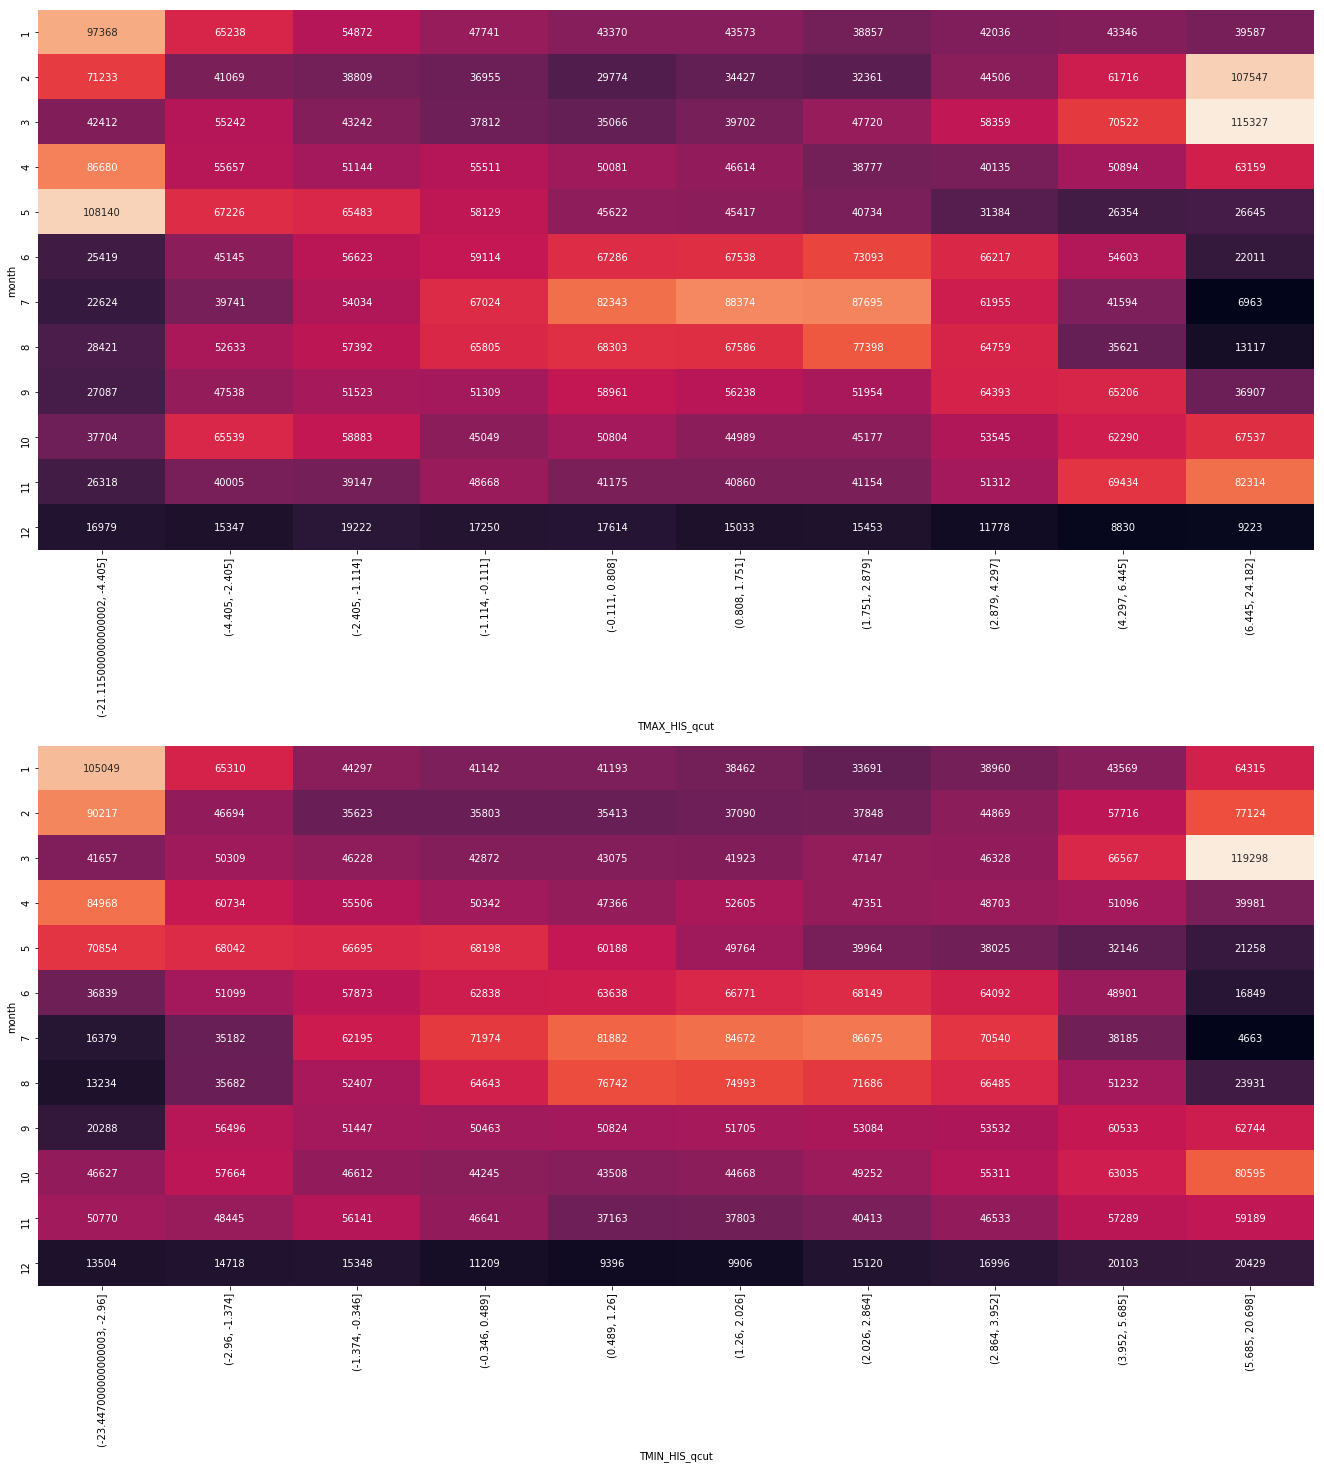

In [60]:
f, axarr = plt.subplots(2, 1, sharey=True)
f.set_size_inches(18.5, 20.5, forward=True)

mon_tmax_df=ill_df.groupby([ill_df.month,ill_df.TMAX_HIS_qcut])['count_daily'].size().to_frame().reset_index()
mon_tmin_df=ill_df.groupby([ill_df.month,ill_df.TMIN_HIS_qcut])['count_daily'].size().to_frame().reset_index()

mon_tmax_heatmap_df=mon_tmax_df.pivot('month','TMAX_HIS_qcut','count_daily')
mon_tmin_heatmap_df=mon_tmin_df.pivot('month','TMIN_HIS_qcut','count_daily')

mon_tmax_heatmap_df[mon_tmax_heatmap_df.columns.tolist()] = mon_tmax_heatmap_df[mon_tmax_heatmap_df.columns.tolist()].fillna(0).astype(np.int64,errors="ignore")
mon_tmin_heatmap_df[mon_tmin_heatmap_df.columns.tolist()] = mon_tmin_heatmap_df[mon_tmin_heatmap_df.columns.tolist()].fillna(0).astype(np.int64,errors="ignore")

ax = sns.heatmap(mon_tmax_heatmap_df, annot=True, fmt="d", ax=axarr[0],cbar=False)
ax = sns.heatmap(mon_tmin_heatmap_df, annot=True, fmt="d", ax=axarr[1],cbar=False)

f.tight_layout()
f.savefig('US_heatmap_rel_month.png') 

### "Fightin' Words" - recreating the study

In [61]:
ill_lowtmax_urban_df=ill_df[(ill_df['TMAX']<=ill_df['TMAX'].quantile(0.25)) & ill_df['URBAN']==True]
ill_lowtmax_rural_df=ill_df[(ill_df['TMAX']<=ill_df['TMAX'].quantile(0.25)) & ill_df['URBAN']==False]

lowtmax_words_urban=np.concatenate(ill_lowtmax_urban_df['txt'].apply(lambda x: x[1:-1]).apply(lambda x: re.sub(r'(^[\#\,\s\-\@\[\]\/]*|\b[\#\,\s\-\@\[\]\/]*(https?//(\w*)\/*(\w*)\s*\,*\s*)*[\,\s\-\@\#\[\]\/]*)', ' ', x).strip().split(' ')).as_matrix()).ravel()
lowtmax_words_rural=np.concatenate(ill_lowtmax_rural_df['txt'].apply(lambda x: x[1:-1]).apply(lambda x: re.sub(r'(^[\#\,\s\-\@\[\]\/]*|\b[\#\,\s\-\@\[\]\/]*(https?//(\w*)\/*(\w*)\s*\,*\s*)*[\,\s\-\@\#\[\]\/]*)', ' ', x).strip().split(' ')).as_matrix()).ravel()


lowtmax_wc_urban=Counter(lowtmax_words_urban)
lowtmax_wc_rural=Counter(lowtmax_words_rural)

ltmax_wc_urban_df = pd.DataFrame(lowtmax_wc_urban.items(), columns=['Word', 'Count'])
ltmax_wc_rural_df = pd.DataFrame(lowtmax_wc_rural.items(), columns=['Word', 'Count'])

ltmax_wc_urban_df = ltmax_wc_urban_df[ltmax_wc_urban_df['Word'].str.isalpha()]
ltmax_wc_rural_df = ltmax_wc_rural_df[ltmax_wc_rural_df['Word'].str.isalpha()]

In [62]:
ltmax_wc_df=pd.merge(ltmax_wc_urban_df,ltmax_wc_rural_df, on="Word",how='outer', suffixes=("_urban","_rural"),sort=True).fillna(0)
ltmax_wc_df['Count_urban_prop']=ltmax_wc_df['Count_urban']/len(lowtmax_words_urban)
ltmax_wc_df['Count_rural_prop']=ltmax_wc_df['Count_rural']/len(lowtmax_words_rural)

words = ltmax_wc_df.Word.as_matrix()
wc_sum_array=(ltmax_wc_df['Count_urban']+ltmax_wc_df['Count_rural']).as_matrix()

In [64]:
def annotate(words, b, top_words=20):
    b_argsort = b.argsort()
    annotate = np.concatenate((b_argsort[:top_words], b_argsort[-top_words:]))
    return annotate

pad_min = lambda x,y=0.1: min(x)-y*(max(x)-min(x))
pad_max = lambda x,y=0.1: max(x)+y*(max(x)-min(x))

def monroe_plot(a,b, word_list=words):
    fig = plt.figure(figsize=(15,15))
    ax=plt.scatter(a, b, s=minmax_scale( b**2, axis=0, feature_range=(0.2,60)))
    plt.xscale('log')
    plt.xlim(xmin=1, xmax=pad_max(a,4))
    plt.ylim(ymin=pad_min(b), ymax=pad_max(b))
    
    partisan_words = annotate(word_list, b)
    text_pos = minmax_scale( list(range(40)), axis=0, feature_range=(0.15,0.87))
    font_sizes = minmax_scale( np.fromiter((map(lambda i: b[i]**2, partisan_words)), dtype=np.float), axis=0, feature_range=(8,24))
    for i,idx in enumerate(partisan_words):
        plt.annotate(word_list[idx], (a[idx], b[idx]), fontsize=font_sizes[i])
        plt.text(0.895, text_pos[i], word_list[idx], transform=fig.transFigure, fontsize=font_sizes[i],
            verticalalignment='top', horizontalalignment='right')
        
    plt.axhspan(0, plt.ylim()[1], facecolor='r', alpha=0.2)
    plt.axhspan(plt.ylim()[0],0 , facecolor='b', alpha=0.2)
    #plt.axhspan(0, 0.5, facecolor='0.2', alpha=0.5)
    plt.show()

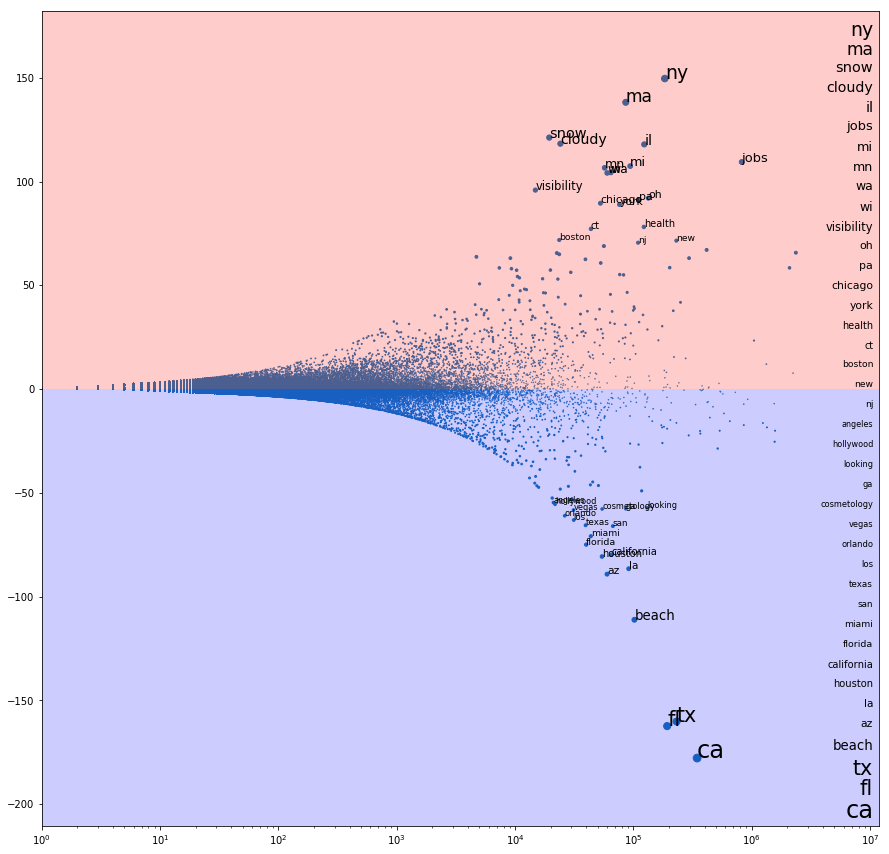

In [65]:
alpha = 0.000000000000001
left=ltmax_wc_df['Count_urban'].as_matrix()
right=ltmax_wc_df['Count_rural'].as_matrix()

left_side = (left + np.full(left.shape, alpha)) / (np.full(left.shape,len(lowtmax_words_urban)+ alpha*left.shape[0]) - left - np.full(left.shape, alpha))
right_side = (right + np.full(right.shape, alpha)) / (np.full(right.shape, len(lowtmax_words_rural) + alpha*right.shape[0]) - right - np.full(right.shape, alpha))
delta_words = np.apply_along_axis(np.log, 0, left_side) - np.apply_along_axis(np.log, 0, right_side)
sigma = (1/(left + np.full(left.shape, alpha))) + (1/(right + np.full(right.shape, alpha)))
zeta = delta_words / np.apply_along_axis(np.sqrt, 0, sigma)
b = zeta
monroe_plot(wc_sum_array,b)

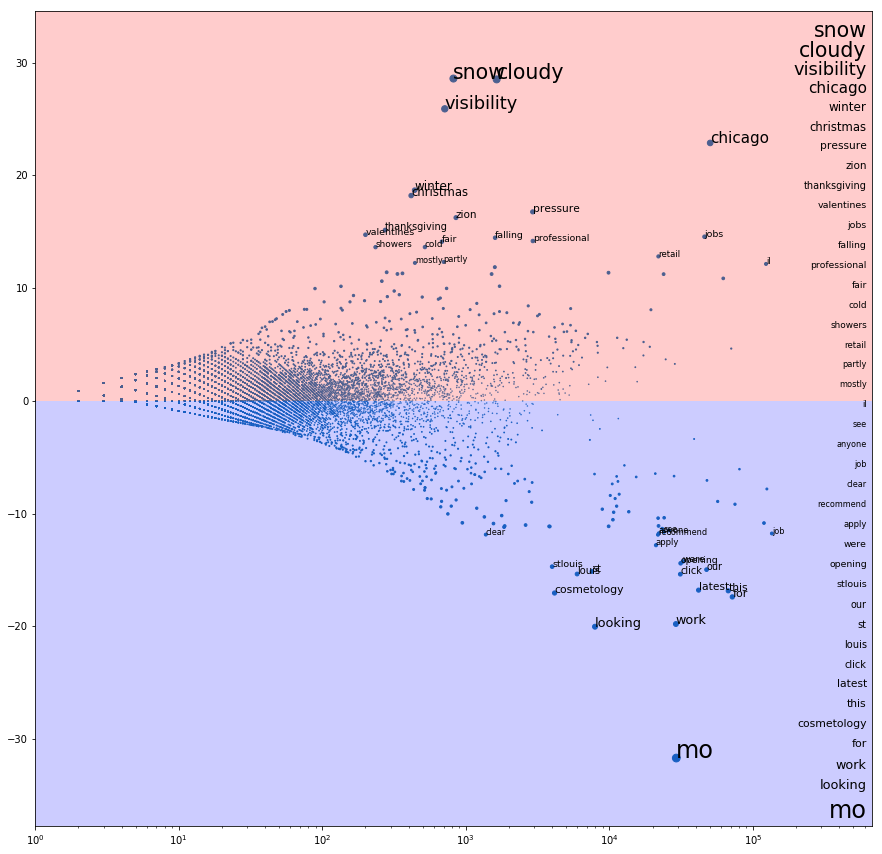

In [491]:
p_left=ltmax_wc_df['Count_urban_prop'].as_matrix()
p_right=ltmax_wc_df['Count_rural_prop'].as_matrix()

epsilon = 0.000000001
left_side = (left + np.full(left.shape, epsilon)+p_left) / (np.full(left.shape, left.sum()+1+epsilon) - left - p_left)
right_side = (right + np.full(right.shape, epsilon)+p_right) / (np.full(right.shape, right.sum()+1+epsilon) - right - p_right)
delta_words = np.apply_along_axis(np.log, 0, left_side) - np.apply_along_axis(np.log, 0, right_side)
sigma = ((1+epsilon)/(left + np.full(left.shape, epsilon)+p_left)) + ((1+epsilon)/(right + np.full(right.shape, epsilon)+p_right))
zeta = delta_words / np.apply_along_axis(np.sqrt, 0, sigma)
b = zeta
monroe_plot(wc_sum_array,b)